In [6]:
from tensorflow.keras.applications import ResNet50
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
import sys
sys.path.append('..')  
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmentation_generator_batch_size import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical

In [7]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

In [8]:
class CIFAR10ResNetGenerator(Sequence):
    def __init__(self, x_data, y_data, batch_size=32, shuffle=True):
        self.x = x_data
        self.y = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x))

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x = self.x[batch_indices]
        batch_y = self.y[batch_indices]

        batch_x_resized = np.array([cv2.resize(img, (224, 224)) for img in batch_x]) #resizing the image

        batch_x_preprocessed = preprocess_input(batch_x_resized.astype(np.float32)) #(s1,s2, channels) -> (batch, s1,s2, channels)

        return batch_x_preprocessed, batch_y

In [9]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# Konwersja do RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2270s 1s/step - accuracy: 0.7753 - loss: 0.6556 - val_accuracy: 0.8743 - val_loss: 0.3418
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2370s 1s/step - accuracy: 0.8543 - loss: 0.3941 - val_accuracy: 0.8796 - val_loss: 0.3281
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2365s 1s/step - accuracy: 0.8652 - loss: 0.3725 - val_accuracy: 0.8904 - val_loss: 0.2963
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2380s 1s/step - accuracy: 0.8672 - loss: 0.3636 - val_accuracy: 0.8875 - val_loss: 0.3125
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2367s 1s/step - accuracy: 0.8767 - loss: 0.3398 - val_accuracy: 0.8885 - val_loss: 0.2970


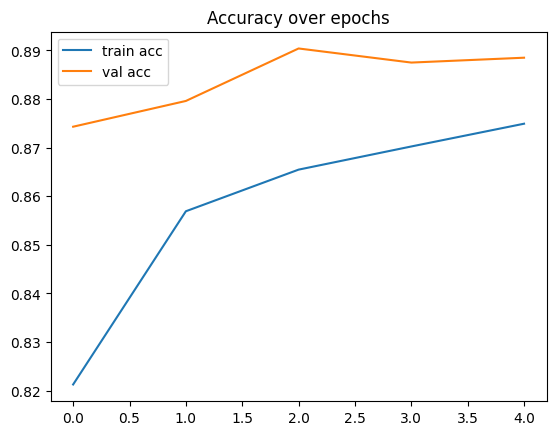

In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy', # changed loss
              metrics=['accuracy'])

train_gen = CIFAR10ResNetGenerator(X_train, Y_train, batch_size=32)
test_gen = CIFAR10ResNetGenerator(X_test, Y_test, batch_size=32, shuffle=False)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [11]:
model.save("restnet_random_mnist.keras")